# Introduction
Many Natural Processing models and alorithms are defined to work on texts that have undergone some pre-processing.
Typical pre-processing steps are:
1. Tokenising the text.
    1. Splitting the text into separate units for each word.
    2. Grouping these tokens in separate sentences.
3. Part of Speech tagging the words, i.e. labeling them as Noun, Verb, etc.
4. Parsing word dependencies in each sentence, building a graph depicting the relationship of words within a sentence.

Other typical pre-processing steps are stemming and lemmatization. Both methods aim to reduce word tokens to their base form, for example `achieved` might be converted to `achieve`. 
The difference between stemming and lemmatization is that stemming typically uses some heuristic to cut of the end of words, and the resulting tokens might not be real words.
Lemmatization on the other hand uses vocabularies and linguistic analysis to turn the word into its base form, its `lemma`.

Many wordbanks are structured using the [CoNLL-U](http://universaldependencies.org/format.html) format, which includes POS-tags, word dependencies, lemma/stem etc. 
Being able to convert unstructured text data CoNLL-U is very useful if you want to apply a method expecting CoNLL-U format on your own unstructured text data.

In this notebook I aim to create a Part of Speech (POS) tagger for word- and sentence-tokenised text.
To train and evaluate my model I will be using text data already in CoNLL-U format, which means I do not need to apply any tokenisation myself. 

In early 2017 I took a course in Natrual Language Processing at Linköping University where me and my lab partner got to implement both a Part of Speech tagger and an unlabeled dependency parser (a dependency parser that does not put names on the relationships in a sentence). 
We used a single layer perceptron as classifier for both the Part of Speech tagger and the Dependency Parser.
This time around I will explore some other possibilities!

# The data
For me it would be nice to compare my results me and my lab partner got last time around, so I will opt to use the same training and test data:
[Universal Dependencies - English Web Treebank](http://universaldependencies.org/treebanks/en_ewt/index.html), a CoNLL-U formart corpus with 254 830 words and 16 622 sentences in english *taken from various web media including weblogs, newsgroups, emails, reviews, and Yahoo! answers*.

## Load the Data
First lets load the training data and convert it to a python dictionary and a pandas data frame.
I use the [conllu](https://github.com/EmilStenstrom/conllu) python package to parse the CoNLL-U files to dictionaries.

In [1]:
import conllu

Read the data.

In [158]:
directory = 'UD/UD_English-EWT'
with open('{}/en_ewt-ud-train.conllu'.format(directory), 'r', encoding='utf-8') as f:
    train_text = f.read()
    
directory = 'UD/UD_English-EWT'
with open('{}/en_ewt-ud-dev.conllu'.format(directory), 'r', encoding='utf-8') as f:
    dev_text = f.read()
    
directory = 'UD/UD_English-EWT'
with open('{}/en_ewt-ud-test.conllu'.format(directory), 'r', encoding='utf-8') as f:
    test_text = f.read()

Convert it to a dictionary.

In [159]:
train_dict = conllu.parse(train_text)
dev_dict = conllu.parse(dev_text)
test_dict = conllu.parse(test_text)

Count sentences and tokens.

In [4]:
from functools import reduce

n_train_sentences = len(train_dict)
n_train_tokens = reduce(lambda x, y: x + len(y), train_dict, 0)

print("The training set contains {} sentences and {} tokens".format(n_train_sentences, n_train_tokens))

The training set contains 12543 sentences and 204607 tokens


Store the data in a Pandas DataFrame for easier analysis.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [6]:
def conllu_dict_to_dataframe(conllu_dict):
    # Assign a sentence id to each token
    for i, sentence in enumerate(conllu_dict):
        for token in sentence:
            token['sentence_id'] = i
    flattened_dict = reduce(lambda x, y: x + y, conllu_dict)
    return pd.DataFrame(flattened_dict)

In [7]:
training_df = conllu_dict_to_dataframe(train_dict)

## Explore the Data
My goal with this task is not to create a POS-tagger that does a perfect job for this exact data, so I won't spend to much time exploring the specifics of the data set. But it is interesting to at least get a feel for its contents.

I will be POS-tagging tokens with the rest of their sentence available, this means that the data I am interested in is:
* `form`, the token being tagged.
* `upostag`, the target label.
* Words with the same sentence_id, and their positions in relation to the word being classified. I will not have access to deps.

I could possibly also apply stemming or lemmatization to sentences before POS-tagging, of course converting a token to its base form could give it a new correct POS-tag, so I would only use the lemma as a complementary feature.
However, I will ignore lemma for now but possibly add it in a later stage.

In [8]:
training_df.head()

,id,form,lemma,upostag,xpostag,feats,head,deprel,deps,misc,sentence_id
0,1.0,Al,Al,PROPN,NNP,{'Number': 'Sing'},0.0,root,"[(root, 0)]",{'SpaceAfter': 'No'},0
1,2.0,-,-,PUNCT,HYPH,None,1.0,punct,"[(punct, 1)]",{'SpaceAfter': 'No'},0
2,3.0,Zaman,Zaman,PROPN,NNP,{'Number': 'Sing'},1.0,flat,"[(flat, 1)]",None,0
3,4.0,:,:,PUNCT,:,None,1.0,punct,"[(punct, 1)]",None,0
4,5.0,American,american,ADJ,JJ,{'Degree': 'Pos'},6.0,amod,"[(amod, 6)]",None,0


### Unique tokens

In [9]:
training_df['form'].nunique()

19672

### Most common tokens

In [10]:
training_df['form'].value_counts()[:10]

.      8640
the    8152
,      7021
to     5076
and    4855
a      3609
of     3589
I      3122
in     2911
is     2153
Name: form, dtype: int64

### Token frequencies
I bet there are many tokens that appear very few times, perhaps just 1. Lets get a feel for how the frequencies of each token is distributed.

In [11]:
import numpy as np

In [12]:
low_freqs = np.arange(1, 21, 1)

In [13]:
val_counts = training_df['form'].value_counts()

In [14]:
occurrences = [100 * (val_counts >= i).sum() / val_counts.count() for i in low_freqs]

(1, 20)

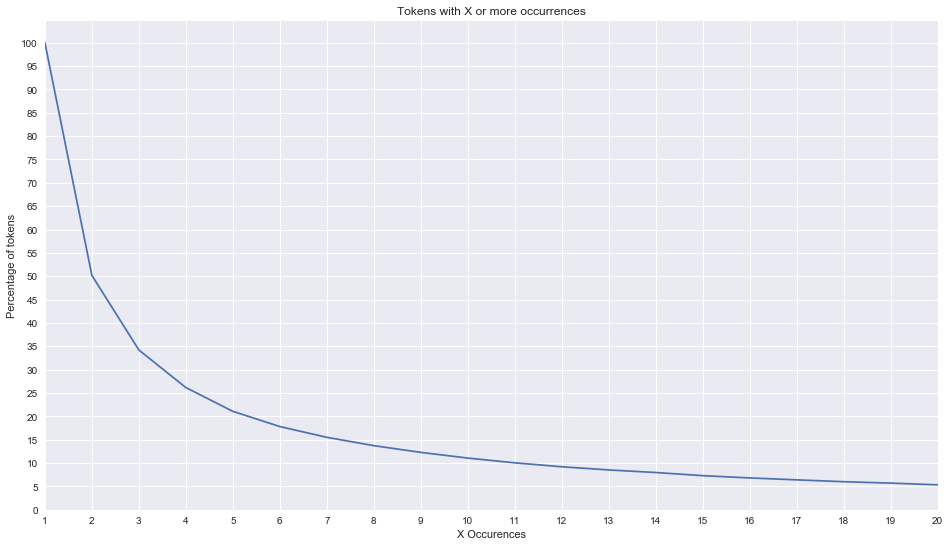

In [15]:
f, ax = plt.subplots(figsize=(16, 9))
plt.plot(low_freqs, occurrences)
ax.xaxis.set_ticks(low_freqs);
ax.yaxis.set_ticks(np.arange(0, 101, 5));
ax.set_ylabel('Percentage of tokens')
ax.set_xlabel('X Occurences')
ax.set_title('Tokens with X or more occurrences')
ax.set_xlim([1, 20])

About 20% of tokens in the training set occur 5 or more times, only 5% appear 20 or more times. 50% of tokens only appear one time.

How I handel the sparsity of the data could have a large impact on my models performance and especially on runtime and memory efficiency.

### Part of Speech Tags

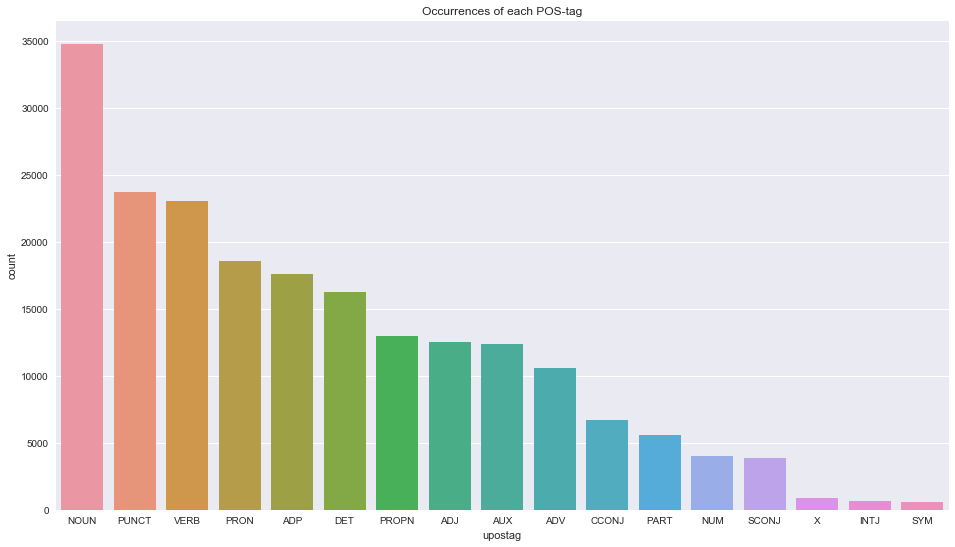

In [16]:
f, ax = plt.subplots(figsize=(16,9))
sns.countplot(x='upostag', data = training_df, order=training_df['upostag'].value_counts().index, ax=ax)
ax.set_title("Occurrences of each POS-tag")

### Sentence length

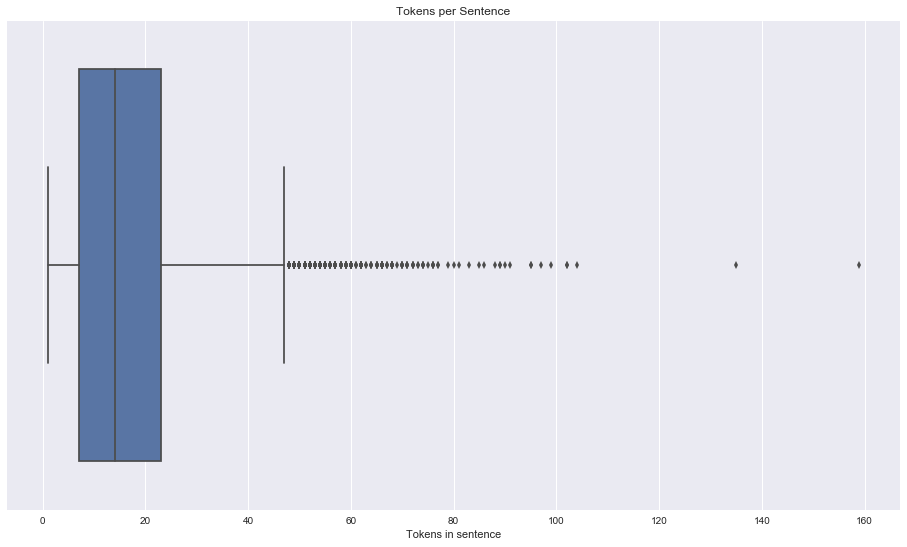

In [17]:
f, ax = plt.subplots(figsize=(16,9))
sns.boxplot(training_df.groupby('sentence_id').agg({'form' : 'count'}), ax=ax)
ax.set_xlabel('Tokens in sentence')
ax.set_title('Tokens per Sentence')

Most sentences are shorter than ~25 words, but there exists some extreme cases.

### Suffixes and prefixes
I plan on using suffixes and prefixes of different length as features, lets examine how many distinct ones there are.

In [34]:
training_df['suffix2'] = training_df['form'].apply(lambda x: x[-2:].lower() if len(x) >= 2 else None)
training_df['suffix3'] = training_df['form'].apply(lambda x: x[-3:].lower() if len(x) >= 3 else None)
training_df['prefix2'] = training_df['form'].apply(lambda x: x[:2].lower() if len(x) >= 2 else None)
training_df['prefix3'] = training_df['form'].apply(lambda x: x[:3].lower() if len(x) >= 3 else None)

In [35]:
print("{} unique suffixes of length 2".format(training_df['suffix2'].nunique()))
print("{} unique suffixes of length 3".format(training_df['suffix3'].nunique()))
print("{} unique prefixes of length 2".format(training_df['prefix2'].nunique()))
print("{} unique prefixes of length 3".format(training_df['prefix3'].nunique()))

748 unique suffixes of length 2
2912 unique suffixes of length 3
744 unique prefixes of length 2
2930 unique prefixes of length 3


Quite a lot of unique suffixes and prefixes. 
The length two strings are actually more than $$25^{2}$$, which would be the theoretical maximum if only alphabetical characters were used.
The length three strings are much fewer than the theoretical maximum though.

Regardless, encoding all these unique strings will be challenging.

In [39]:
training_df[['suffix2', 'suffix3', 'prefix2', 'prefix3']].isnull().sum(0)

suffix2    31767
suffix3    64536
prefix2    31767
prefix3    64536
dtype: int64

A lot of tokens are too short to extract suffixes and prefixes. I will have to figure out a good way of representing this as well.

# Feature Engineering
As I have some previous experience with POS-tagging I will not spend to much time investigating new features.
Rather, I will opt to use features that I already know work well.

Worth to note is that I will POS tag the words sequentially. I.E. I start with the first word, estimate its POS-tag, and then move on to the next word without ever reconsidering the first words POS-tag.

List of features:
* The word itself
* The probabilities that the word belong to each label based on Maximum Likelihood Estimation on the training data using only the word it seld as a feature, this will be fetched from a predefined dictionary. (One entry per label)
* The word left of the word in the sentence
* The word right of the word in the sentence 
* The POS-tag of the left word in the sentence (One-hot encoded)
* Token length, normalised (float)
* Suffix, last two characters 
* Suffix, last three characters 
* Prefix, first two characters 
* Prefix, first three characters

I need to find a good representation of the categorical features. 
POS-tag of the previous word is obviously fine to one-hot encode, as we don't have to many labels.
Representing individual words, as well as suffixes and prefixes, is a completely different story though.
If I would one-hot encode the words with no dimensionality reduction I would end up with more than 19 000 dimensions per word, and I have three features where I need to represent words.
I would quickly end up with over 60 000 dimensions, most always set to 0.

In my previous implementation the Perceptron classifier was based on Python dictionaries, with entries for each categorical value.
Representing categoricals with dictionaries is a solid way of handeling the sparsity of data, as vector multiplications could be done elementwise very effectively. 
However, such a set up is not compatible with my ML frameworks of choice, `sklearn` and `keras`.

To represent each token I will be using so called word embeddings.
A word embedding is simply a word represented as a vector, so one-hot encoded words fall into this category.
The word embeddings I will use are a little bit more sophisticated though, using fewer dimensions and actually assigning some meaning to the different dimensions.
[Word2vec](https://en.wikipedia.org/wiki/Word2vec) was created by Google, and build word embeddings based on word proximity in training sentences. 
The assumption is that if two different words often appear in the same contexts they are probably similar, and have word embedding that are close to each other. 

The word embedding created by word2vec also have several other interesting properties. For example, consider the vector representation of the word king, G('king'). 
If we subtract G('man') and add G('woman'), we would get a vector very close to the vector G('queen'). 

I am very excited to see what effects this has on my model!

One thing to note here, that I think is very important, is that training a word embedding model does not require POS-tags. 
Had this been the case it would not have made any sense to use it as a pre-processing step for my POS-tagger.
(It is possible to use POS-tags as features for word embeddings, but Googles word2vec implementation only looks at nearby words.)

## Word2Vec
Lets start by converting our tokens into word embeddings.

In [97]:
from gensim.models import Word2Vec

C:\Users\Gustav\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [160]:
train_sentences = [[token['form'] for token in sentence] for sentence in train_dict]
train_labels = [[token['upostag'] for token in sentence] for sentence in train_dict]

dev_sentences = [[token['form'] for token in sentence] for sentence in dev_dict]
dev_labels = [[token['upostag'] for token in sentence] for sentence in dev_dict]

test_sentences = [[token['form'] for token in sentence] for sentence in test_dict]
test_labels = [[token['upostag'] for token in sentence] for sentence in test_dict]

In [138]:
w2v = Word2Vec(train_sentences, min_count=5, size=25)

### Quick demonstration of neat properties

In [139]:
w2v.wv.similar_by_word('king')

[('signs', 0.9950331449508667),
 ('change', 0.9950103163719177),
 ('reply', 0.9943593740463257),
 ('pull', 0.9942187666893005),
 ('guy', 0.9942054152488708),
 ('down', 0.9941377639770508),
 ('kids', 0.9940827488899231),
 ('playing', 0.9940721392631531),
 ('provide', 0.993903398513794),
 ('refer', 0.9938868880271912)]

In [140]:
w2v.wv.similar_by_vector(w2w.wv['king'] - w2w.wv['man'] + w2w.wv['woman'])

[('Otherwise', 0.5614035129547119),
 ('know', 0.5261061191558838),
 ('do', 0.5083385705947876),
 ("n't", 0.4882880449295044),
 ('you', 0.4832954406738281),
 ('want', 0.47248315811157227),
 ('forget', 0.4623956084251404),
 ('if', 0.43421512842178345),
 ('rush', 0.4218112826347351),
 ('I', 0.3984465003013611)]

Ouch, this does not look good at all...
I think my training data is way to small to create valuable word embeddings.
I will try using Google pre trained model instead.
The model can be found [here](https://code.google.com/archive/p/word2vec/), it was pretrained on about 100 billion(!!!) words from the Google News data set, and encodes words into 300 dimensional word embeddings.

There are some drawbacks of using this model though:
1. It's huge, mapping over 3 million unique tokens to word embeddings. The upside is that I will hopefully encounter few unkown tokens in the EWT data, but it also means that the model will be slow to use at it might not fit in memory.
2. It is trained of data that has barely been pre-processed, so it contains misspellings and some nonsense tokens. 

In [18]:
from gensim.models import KeyedVectors

C:\Users\Gustav\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [19]:
news_w2v = KeyedVectors.load_word2vec_format('word2vec/GoogleNews-vectors-negative300.bin', binary=True)

In [20]:
news_w2v.similar_by_word('king')

[('kings', 0.7138045430183411),
 ('queen', 0.6510956883430481),
 ('monarch', 0.6413194537162781),
 ('crown_prince', 0.6204219460487366),
 ('prince', 0.6159993410110474),
 ('sultan', 0.5864823460578918),
 ('ruler', 0.5797567367553711),
 ('princes', 0.5646552443504333),
 ('Prince_Paras', 0.5432944297790527),
 ('throne', 0.5422105193138123)]

In [21]:
news_w2v.similar_by_vector(news_w2v['king'] - news_w2v['man'] + news_w2v['woman'])

[('king', 0.8449392318725586),
 ('queen', 0.7300517559051514),
 ('monarch', 0.6454660892486572),
 ('princess', 0.6156250834465027),
 ('crown_prince', 0.5818676352500916),
 ('prince', 0.577711820602417),
 ('kings', 0.5613664388656616),
 ('sultan', 0.5376776456832886),
 ('Queen_Consort', 0.5344247817993164),
 ('queens', 0.5289887189865112)]

In [22]:
news_w2v.similar_by_word('London')

[('EURASIAN_NATURAL_RESOURCES_CORP.', 0.6739697456359863),
 ('Londons', 0.6536128520965576),
 ('Islamabad_Slyvia_Hui', 0.6375559568405151),
 ('Wandsworth', 0.6133824586868286),
 ('Canary_Wharf', 0.6119279861450195),
 ('Battersea', 0.6080656051635742),
 ('Croydon', 0.6077532768249512),
 ('Holborn', 0.5971218347549438),
 ('Ealing', 0.5936053991317749),
 ('Stock_Exchange_LSE_TRIL', 0.5932283401489258)]

In [23]:
news_w2v.similar_by_vector(news_w2v['London'] - news_w2v['England'] + news_w2v['Germany'])

[('Germany', 0.6169734597206116),
 ('Berlin', 0.6122506856918335),
 ('Dusseldorf', 0.6023740768432617),
 ('Frankfurt', 0.5981025695800781),
 ('London', 0.58940589427948),
 ('Düsseldorf', 0.5878291726112366),
 ('Munich', 0.5780648589134216),
 ('Munich_Germany', 0.5410465002059937),
 ('Budapest', 0.5359379053115845),
 ('Duesseldorf', 0.5313573479652405)]

In [24]:
news_w2v.similar_by_word('Germany')

[('Austria', 0.7461062073707581),
 ('German', 0.7178748846054077),
 ('Germans', 0.6628648042678833),
 ('Switzerland', 0.6506868600845337),
 ('Hungary', 0.6504982709884644),
 ('Germnay', 0.649348258972168),
 ('Netherlands', 0.6437496542930603),
 ('Cologne', 0.6430779695510864),
 ('symbol_RSTI', 0.6389946937561035),
 ('Annita_Kirsten', 0.6342948079109192)]

The word operations are perhaps not spot on, but it's still damn impressive how London - England + Germany has Berlin as top 2 closest words.

## Initial probability estimations
I will build a dictionary associating each token in the training set vocabulary with a prior probability estimate that it should be labeled with each POS tag.

In [64]:
from sklearn.preprocessing import OneHotEncoder

In [50]:
occurence_df = training_df.groupby(['form', 'upostag']).agg({'id' : 'count'}).reset_index()

<17x17 sparse matrix of type '<class 'numpy.float64'>'
	with 17 stored elements in Compressed Sparse Row format>

In [99]:
pos_tags = training_df['upostag'].unique()
pos_label_dict = dict(zip(pos_tags, OneHotEncoder().fit_transform(X=np.arange(len(pos_tags)).reshape(-1,1)).toarray()))

In [52]:
apriori_dict = {}
for token in occurence_df['form']:
    df = occurence_df[occurence_df['form'] == token]
    count = df['id'].sum()
    apriori_dict[token] = [df[df['upostag'] == pos]['id'].sum() / count for pos in pos_tags]

In [57]:
list(zip(pos_tags, apriori_dict['run']))

[('PROPN', 0.0),
 ('PUNCT', 0.0),
 ('ADJ', 0.021739130434782608),
 ('NOUN', 0.21739130434782608),
 ('VERB', 0.7608695652173914),
 ('DET', 0.0),
 ('ADP', 0.0),
 ('AUX', 0.0),
 ('PRON', 0.0),
 ('PART', 0.0),
 ('SCONJ', 0.0),
 ('NUM', 0.0),
 ('ADV', 0.0),
 ('CCONJ', 0.0),
 ('X', 0.0),
 ('INTJ', 0.0),
 ('SYM', 0.0)]

## Encoding the features

In [162]:
def get_features(i, sentence):
    """ Returns a numpy array with the features for the token with index i in 
        a sentence, given a list of POS-tags for all previous words.
    Args:
        i (int): The index of the token that is to be featurized.
        sentence (iterable with strings): An iterable with strings, representing the sentence the token appears in.
        tags (iterable with iterables with int): An iterable with one-hot encoded representations for the POS-tags of previous tokens in the sentence. (0, ..., i-1)

    Returns:
        np.array: A numpy array with features for the given token.
    """
    token = sentence[i]
    
    # The token
    try:
        token_enc = news_w2v[token]
    except KeyError:
        token_enc = np.zeros(300, dtype='float32')
    
    # A priori estimates
    try:
        apriori = apriori_dict[token]
    except KeyError:
        apriori = np.zeros(17, dtype='float32')
    
    # Previous word 
    # Use "BOS" if first word. I'm not sure why BOS and EOS is part of the Google pre trained model, 
    # either they extended all sentences with these tags or the words actually apeared in the data.
    # Regardless, I will use them as such.
    try:
        previous_word = news_w2v[sentence[i-1] if i > 0 else "BOS"]
    except KeyError:
        previous_word = np.zeros(300, dtype='float32')
    
    # Next word
    try:
        next_word = news_w2v[sentence[i+1] if i < len(sentence) - 1 else "EOS"]
    except KeyError:
        next_word = np.zeros(300, dtype='float32')
    
    
    # Previous tag, use X if this is the first word
    #previous_tag = tags[i-1] if i > 0 else pos_label_dict["X"]
    
    return np.concatenate([token_enc, apriori, previous_word, next_word])#, previous_tag])
    
    

In [163]:
features = get_features(0, train_sentences[0])

In [164]:
features.shape

(917,)

Okay, so without using any of the suffix features I send up with 917 features. 

I decided to skip the "POS-tag of previous word" feature as it is not a good fit for standard neural networks, as it requries each instance to be predicted sequentially. 
To extract the features of one word the features of the previous word is needed.

Lets experiment with the current features.

# Models

## Single Layer Perceptron
Lets first evaluate our new features with a model similar to what I used last time, a single layer Perceptron.

In [123]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization

In [169]:
perceptron = Sequential()
perceptron.add(BatchNormalization(input_shape=(917,)))
perceptron.add(Dense(units = len(pos_tags), activation='softmax'))
perceptron.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [166]:
def get_feature_vec(X):
    return np.concatenate([np.array([get_features(i, sentence) for i in range(len(sentence))]) for sentence in X])
def get_label_vec(y):
    return np.concatenate([np.array([pos_label_dict[tok] for tok in sentence]) for sentence in y])

In [165]:
X = get_feature_vec(train_sentences)
X_val = get_feature_vec(dev_sentences)
X_test = get_feature_vec(test_sentences)

In [167]:
y = get_label_vec(train_labels)
y_val = get_label_vec(dev_labels)
y_test = get_label_vec(test_labels)

In [171]:
X_val.shape

(25150, 917)

In [173]:
perceptron.fit(X, y, batch_size=64, epochs=10, validation_data=[X_val, y_val])

Train on 204607 samples, validate on 25150 samples
Epoch 1/10
204607/204607 [==============================] - 29s 139us/step - loss: 0.2580 - acc: 0.9258 - val_loss: 0.2925 - val_acc: 0.9158
Epoch 2/10
204607/204607 [==============================] - 31s 150us/step - loss: 0.1448 - acc: 0.9560 - val_loss: 0.3003 - val_acc: 0.9128
Epoch 3/10
204607/204607 [==============================] - 31s 150us/step - loss: 0.1376 - acc: 0.9572 - val_loss: 0.3218 - val_acc: 0.9113
Epoch 4/10
204607/204607 [==============================] - 36s 178us/step - loss: 0.1325 - acc: 0.9586 - val_loss: 0.3219 - val_acc: 0.9100
Epoch 5/10
204607/204607 [==============================] - 38s 184us/step - loss: 0.1291 - acc: 0.9598 - val_loss: 0.3350 - val_acc: 0.9082
Epoch 6/10
204607/204607 [==============================] - 35s 171us/step - loss: 0.1260 - acc: 0.9607 - val_loss: 0.3538 - val_acc: 0.9047
Epoch 7/10
204607/204607 [==============================] - 34s 168us/step - loss: 0.1252 - acc: 0.9604

90% validation accuracy. 
Our previous Perceptron got about 91% accuracy on the dev set. It was a little bit different though:

* Sequential features based on previous words
* Suffix and Prefix features
* One-hot encoded categoricals

I have fewer features now, but hopefully using word embeddings instead of one-hot encoding could be usefull for more complex models. Lets try with a more complex model, using two hidden layers.

# Deep Neural Network
Lets try adding two hidden layers.

In [179]:
from keras.layers import Dropout

In [187]:
dnn = Sequential()
dnn.add(BatchNormalization(input_shape=(917,)))
dnn.add(Dropout(rate=.25))
dnn.add(Dense(units=300, activation='elu'))
dnn.add(BatchNormalization())
dnn.add(Dense(units=150, activation='elu'))
dnn.add(BatchNormalization())
dnn.add(Dense(units = len(pos_tags), activation='softmax'))
dnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [188]:
from keras.callbacks import EarlyStopping

In [189]:
callbacks = [EarlyStopping(monitor='val_acc', min_delta=0, patience=1, verbose=0, mode='auto')]

In [190]:
dnn.fit(X, y, batch_size=64, epochs=10, validation_data=[X_val, y_val], callbacks=callbacks)

Train on 204607 samples, validate on 25150 samples
Epoch 1/10
204607/204607 [==============================] - 108s 527us/step - loss: 0.2748 - acc: 0.9163 - val_loss: 0.2623 - val_acc: 0.9228
Epoch 2/10
204607/204607 [==============================] - 100s 490us/step - loss: 0.1872 - acc: 0.9399 - val_loss: 0.2485 - val_acc: 0.9271
Epoch 3/10
204607/204607 [==============================] - 110s 537us/step - loss: 0.1608 - acc: 0.9483 - val_loss: 0.2375 - val_acc: 0.9322
Epoch 4/10
204607/204607 [==============================] - 108s 529us/step - loss: 0.1449 - acc: 0.9520 - val_loss: 0.2412 - val_acc: 0.9298


Cool 93% accuracy, this is an improvement over our previous tagger!

In [193]:
predictions = dnn.predict(X_val)

In [194]:
from sklearn.metrics import confusion_matrix

In [212]:
pos_tags

array(['PROPN', 'PUNCT', 'ADJ', 'NOUN', 'VERB', 'DET', 'ADP', 'AUX',
       'PRON', 'PART', 'SCONJ', 'NUM', 'ADV', 'CCONJ', 'X', 'INTJ', 'SYM'], dtype=object)

In [215]:
df = pd.DataFrame(confusion_matrix(predictions, y_val.argmax(1)), columns = pos_tags, index=pos_tags)

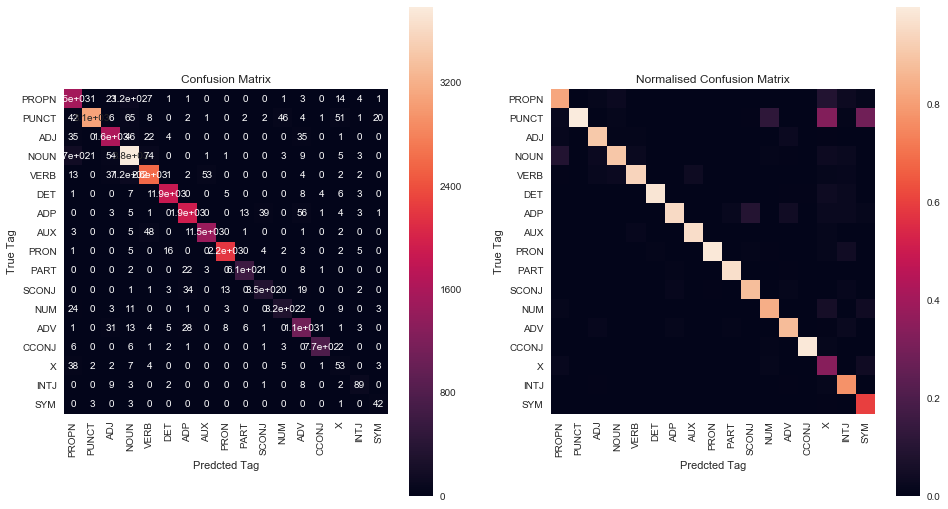

In [267]:
f, ax = plt.subplots(1, 2, figsize=(16,9))

sns.heatmap(df, annot=True, ax=ax[0], square=True)
ax[0].set_ylabel('True Tag')
ax[0].set_xlabel('Predcted Tag')
ax[0].set_title('Confusion Matrix')

sns.heatmap(df / df.sum(0), ax=ax[1], square=True)
ax[1].set_ylabel('True Tag')
ax[1].set_xlabel('Predcted Tag')
ax[1].set_title('Normalised Confusion Matrix')

# Summary
## Results
I built a Part of Speech tagger capable of achieving 93% accuracy on the EWT dev set, this is an improvement of almost 2% units compared to the classifier we built in my NLP course one year ago.

My classifier uses 4 features:
* The word being classified
* The word right befor in the sentence
* The word right after in the sentence
* The a priori probability estimates for the word

To encode words as word embeddings I have used Googles word2vec, pretrained on their news data set.
This has some obvious upsides:
* Significantly reduces the number of dimensions compared to one-hot encoding.
* I can encode words not in my training set, and they will have similar representations as words deemed similar by word2vec.

I did not use sequential features, such as the predicted pos-tag of the previous word. 
Also I decided against using suffixes and prefixes as one-hot encoding them would have significantly increased the number of dimensions of input data.

## What next?
It seems like state of the art performance in POS-tagging as well as Dependency Parsing is achieved using Long short-term memory (LSTM) networks. 
I would like to read up on this and perhaps get back to this task again in the future.